In [1]:
"""
    Package Installation
"""
__author__ = "SakibApon"
__email__ = "sakibapon7@gmail.com"

import os
import pywt
import numpy as np
import pandas as pd
from numpy import argmax
import matplotlib.pyplot as plt
from pandas import DataFrame

import graphviz
import xgboost as xgb
from xgboost import plot_tree
from scipy import signal

import sklearn
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier as DT
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor, AdaBoostClassifier
from sklearn.metrics import classification_report, accuracy_score,precision_score, recall_score, f1_score
from sklearn.metrics import average_precision_score,roc_auc_score, roc_curve, precision_recall_curve

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [2]:
data = pd.read_csv('../input/bledataset/BLE_rssi_after_Gray_Filter_Grid_1.5m_1.25m.csv')

data = data.drop(['date'],axis=1)

#Performance List
l = []

X = data.iloc[:,1:]
y = data.iloc[:,0]

#Encoder
le = LabelEncoder()
y = le.fit_transform(y)

trainX, testX, trainY, testY = train_test_split(X, y, test_size = 0.2, random_state = 0)

## XG Boost

In [3]:
xgb_classifier = xgb.XGBClassifier()
xgb_classifier.fit(trainX, trainY)

"""plot_tree(xgb_classifier,  num_trees=4)
fig = plt.gcf()
fig.set_size_inches(150, 100)
fig.savefig('tree.png')
plt.show()"""

predY_XGB = xgb_classifier.predict(testX)

modelName = "XGB"
accuracy = round(accuracy_score(testY, predY_XGB),4)*100 
precision = round(precision_score(testY, predY_XGB, average='micro'),4)*100 
recall = round(recall_score(testY, predY_XGB, average='micro'),4)*100 
f1 = round(f1_score(testY, predY_XGB, average='micro'),4)*100

l.append([modelName, accuracy, precision, recall, f1])

#my_dict['Mean Absolute Error'] = metrics.mean_absolute_error(testY, predY_XGB)
#my_dict['Mean Squared Error'] = metrics.mean_squared_error(testY, predY_XGB)
#my_dict['Root Mean Squared Error'] = np.sqrt(metrics.mean_squared_error(testY, predY_XGB))

### GaussianNB

In [4]:
gnb = GaussianNB()
gnb.fit(trainX, trainY)
predY=gnb.predict(testX)

modelName = "GaussianNB"
accuracy = round(accuracy_score(testY, predY),4)*100 
precision = round(precision_score(testY, predY, average='micro'),4)*100 
recall = round(recall_score(testY, predY, average='micro'),4)*100 
f1 = round(f1_score(testY, predY, average='micro'),4)*100
l.append([modelName, accuracy, precision, recall, f1])

In [5]:
df = DataFrame (l, columns=[ 'Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score'])
df

,Model,Accuracy,Precision,Recall,F1-Score
0,XGB,64.45,64.45,64.45,64.45
1,GaussianNB,38.68,38.68,38.68,38.68


# 2nd Part

In [6]:
data = pd.read_csv('../input/bledataset/BLE_rssi_after_Gray_Filter_Grid_1.5m_1.25m.csv')

data = data.drop(['date'],axis=1)

X = data.iloc[:,1:]
y = data.iloc[:,0]

trainX, testX, trainY, testY = train_test_split(X, y, test_size= 0.2, random_state=42)

In [7]:
orgtestY = testY

#Learning parameter initialization
windowX = 5
windowY = 5
n_classes = len(data.iloc[:,0].unique())
kernelCNN_Dim=(3,3)
epochs = 200
batch_size = 128

## SVC

### SVC Poly

In [8]:
svcPoly = SVC(kernel='poly', degree=3)
svcPoly.fit(trainX, trainY)
predPolyX = svcPoly.predict(testX)

modelName = "SVC Poly"
accuracy = round(accuracy_score(testY, predPolyX),4)*100 
precision = round(precision_score(testY, predPolyX, average='micro'),4)*100 
recall = round(recall_score(testY, predPolyX, average='micro'),4)*100 
f1 = round(f1_score(testY, predPolyX, average='micro'),4)*100
l.append([modelName, accuracy, precision, recall, f1])

### SVC Sigmoid

In [9]:
svcSigmoid = SVC(kernel='sigmoid')
svcSigmoid.fit(trainX, trainY)
predSigmoidX = svcSigmoid.predict(testX)

modelName = "SVC Sigmoid"
accuracy = round(accuracy_score(testY, predSigmoidX),4)*100 
precision = round(precision_score(testY, predSigmoidX, average='micro'),4)*100 
recall = round(recall_score(testY, predSigmoidX, average='micro'),4)*100 
f1 = round(f1_score(testY, predSigmoidX, average='micro'),4)*100
l.append([modelName, accuracy, precision, recall, f1])

### One-hot encoding

In [10]:
targetY = trainY
targetY=targetY.append(testY)
Y_target=pd.get_dummies(targetY)

totalTrainingRow = int(len(data) * 0.8)

Y_train=Y_target.iloc[0:totalTrainingRow]
Y_test=Y_target.iloc[totalTrainingRow:]

### DNN 

In [15]:
model = Sequential()
model.add(Dense(50, input_shape=(trainX.shape[1],), activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(Y_train.shape[1], activation='softmax'))
model.summary()

#callbacks
checkpoint = ModelCheckpoint('DNN.h5', monitor='val_loss', mode='min', save_best_only=True, verbose=1)
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience = 10, verbose=1, restore_best_weights=True)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=5, verbose=1, factor=0.2, min_lr=0.01)
callbacks = [earlystop, checkpoint, learning_rate_reduction]


metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes = Y_train.shape[1]), 
               tf.keras.metrics.AUC(), tfa.metrics.CohenKappa(num_classes = Y_train.shape[1])]

model.compile(loss='categorical_crossentropy', metrics = metrics, optimizer='adam')

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 50)                300       
_________________________________________________________________
dense_7 (Dense)              (None, 100)               5100      
_________________________________________________________________
dense_8 (Dense)              (None, 95)                9595      
Total params: 14,995
Trainable params: 14,995
Non-trainable params: 0
_________________________________________________________________


In [16]:
model.fit(trainX, Y_train, batch_size=batch_size, epochs=epochs, validation_data=(testX, Y_test), callbacks = callbacks)

Epoch 1/200
40/40 [==============================] - 3s 29ms/step - loss: 9.2362 - accuracy: 0.0343 - precision_2: 0.0653 - recall_2: 0.0096 - f1_score: 0.0175 - auc_2: 0.5513 - cohen_kappa: 0.0177 - val_loss: 4.8751 - val_accuracy: 0.0626 - val_precision_2: 0.2647 - val_recall_2: 0.0070 - val_f1_score: 0.0210 - val_auc_2: 0.6359 - val_cohen_kappa: 0.0434

Epoch 00001: val_loss improved from inf to 4.87508, saving model to DNN.h5
Epoch 2/200
40/40 [==============================] - 0s 6ms/step - loss: 4.1558 - accuracy: 0.0715 - precision_2: 0.3885 - recall_2: 0.0106 - f1_score: 0.0428 - auc_2: 0.7545 - cohen_kappa: 0.0513 - val_loss: 3.6413 - val_accuracy: 0.1096 - val_precision_2: 0.5667 - val_recall_2: 0.0133 - val_f1_score: 0.0678 - val_auc_2: 0.8392 - val_cohen_kappa: 0.0915

Epoch 00002: val_loss improved from 4.87508 to 3.64127, saving model to DNN.h5
Epoch 3/200
40/40 [==============================] - 0s 6ms/step - loss: 3.4676 - accuracy: 0.1140 - precision_2: 0.4892 - recall

In [20]:
#modelPred = argmax(model.predict(testX),axis=1)
modelName = "DNN"
accuracy =  0.4158  * 100 
precision =  0.6494 * 100 
recall =  0.2060 * 100 
f1 =  0.3830  * 100 
l.append([modelName, accuracy, precision, recall, f1])

### CNN

In [17]:
x_test = testX
y_test = Y_test

# implement code to predict using CNN

#convert 1D pattern to 1Dx1D matrix
def OnedToTwoDClone(pattern):
    Array2D = [pattern] + [pattern for i in pattern]
    return np.vstack(tuple(Array2D))

#convert 1D pattern to 1Dxrows matrix
def OneToTwoDClone(pattern, rows):
    return np.reshape(np.tile(pattern, rows), len(pattern)*rows)

#convert whole dataset to size of columns x rows and flatten them 
#then generate the dataset
trainX = np.tile(trainX, np.shape(trainX)[1])
testX = np.tile(testX, np.shape(testX)[1])

print(np.shape(trainX))
print(np.shape(testX))

trainX = trainX.astype('float32')
testX = testX.astype('float32')
maxVal = np.max(np.max(data.iloc[:,1:-1]))

trainX /= maxVal
testX /= maxVal
# Change the data dimensionality according to your data here
trainX = trainX.reshape(trainX.shape[0], windowX, windowY, 1)
testX = testX.reshape(testX.shape[0], windowX, windowY, 1)

(5105, 25)
(1277, 25)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in true_divide
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in true_divide
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


In [18]:
modelCNN = Sequential()
modelCNN.add(Conv2D(150, kernel_size=kernelCNN_Dim, strides=(1,1), padding='valid', activation='relu', input_shape=(windowX, windowY,1)))
modelCNN.add(Conv2D(200, kernel_size=kernelCNN_Dim, strides=(1,1), padding='valid', activation='relu'))
modelCNN.add(Flatten())
modelCNN.add(Dense(100, activation='relu'))
modelCNN.add(Dense(150, activation='relu'))
modelCNN.add(Dense(n_classes, activation='softmax'))#Number of classes 55
metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes = n_classes), 
               tf.keras.metrics.AUC(), tfa.metrics.CohenKappa(num_classes = n_classes)]

#callbacks
checkpoint = ModelCheckpoint('CNN.h5', monitor='val_loss', mode='min', save_best_only=True, verbose=1)
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience = 10, verbose=1, restore_best_weights=True)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=5, verbose=1, factor=0.2, min_lr=0.01)
callbacks = [earlystop, checkpoint, learning_rate_reduction]

modelCNN.compile(loss='categorical_crossentropy', metrics = metrics, optimizer='adam')
modelCNN.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 3, 3, 150)         1500      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1, 1, 200)         270200    
_________________________________________________________________
flatten (Flatten)            (None, 200)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 100)               20100     
_________________________________________________________________
dense_10 (Dense)             (None, 150)               15150     
_________________________________________________________________
dense_11 (Dense)             (None, 95)                14345     
Total params: 321,295
Trainable params: 321,295
Non-trainable params: 0
________________________________________________

In [19]:
modelCNN.fit(trainX, Y_train, batch_size=batch_size, epochs=epochs, validation_data=(testX, Y_test), callbacks = callbacks)

Epoch 1/200
40/40 [==============================] - 3s 43ms/step - loss: 4.5507 - accuracy: 0.0372 - precision_3: 0.0000e+00 - recall_3: 0.0000e+00 - f1_score: 0.0151 - auc_3: 0.5000 - cohen_kappa: -5.2905e-04 - val_loss: 4.5484 - val_accuracy: 0.0462 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_f1_score: 9.2972e-04 - val_auc_3: 0.5000 - val_cohen_kappa: 0.0000e+00

Epoch 00001: val_loss improved from inf to 4.54840, saving model to CNN.h5
Epoch 2/200
40/40 [==============================] - 1s 20ms/step - loss: 4.5436 - accuracy: 0.0411 - precision_3: 0.0000e+00 - recall_3: 0.0000e+00 - f1_score: 8.3181e-04 - auc_3: 0.5000 - cohen_kappa: 0.0000e+00 - val_loss: 4.5433 - val_accuracy: 0.0462 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_f1_score: 9.2972e-04 - val_auc_3: 0.5000 - val_cohen_kappa: 0.0000e+00

Epoch 00002: val_loss improved from 4.54840 to 4.54332, saving model to CNN.h5
Epoch 3/200
40/40 [==============================] - 1s 25ms/step -

In [ ]:
modelCNNPred = argmax(modelCNN.predict(testX),axis=1)

In [21]:
modelName = "CNN"
accuracy = 0.0462  * 100 
precision = 0.000 * 100 
recall = 0.0000 * 100 
f1 = 0.0000 * 100 
l.append([modelName, accuracy, precision, recall, f1])

In [24]:
l

[['XGB', 64.45, 64.45, 64.45, 64.45],
 ['GaussianNB', 38.68, 38.68, 38.68, 38.68],
 ['SVC Poly', 51.61, 51.61, 51.61, 51.61],
 ['SVC Sigmoid', 4.62, 4.62, 4.62, 4.62],
 ['DNN', 41.58, 64.94, 20.599999999999998, 38.3],
 ['CNN', 4.62, 0.0, 0.0, 0.0]]

In [22]:
df = DataFrame (l, columns=[ 'Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score'])
df = df.sort_values(by='Accuracy', ascending= True)
df

,Model,Accuracy,Precision,Recall,F1-Score
3,SVC Sigmoid,4.62,4.62,4.62,4.62
5,CNN,4.62,0.00,0.00,0.00
1,GaussianNB,38.68,38.68,38.68,38.68
4,DNN,41.58,64.94,20.60,38.30
2,SVC Poly,51.61,51.61,51.61,51.61
0,XGB,64.45,64.45,64.45,64.45


In [ ]:
"""ax = df.plot(x='Model',  kind='bar',title='Performance Evaluation',legend=True, figsize=(15, 10))
plt.grid()
ax.set_xlabel("x label")
ax.set_ylabel("Algorithms")"""

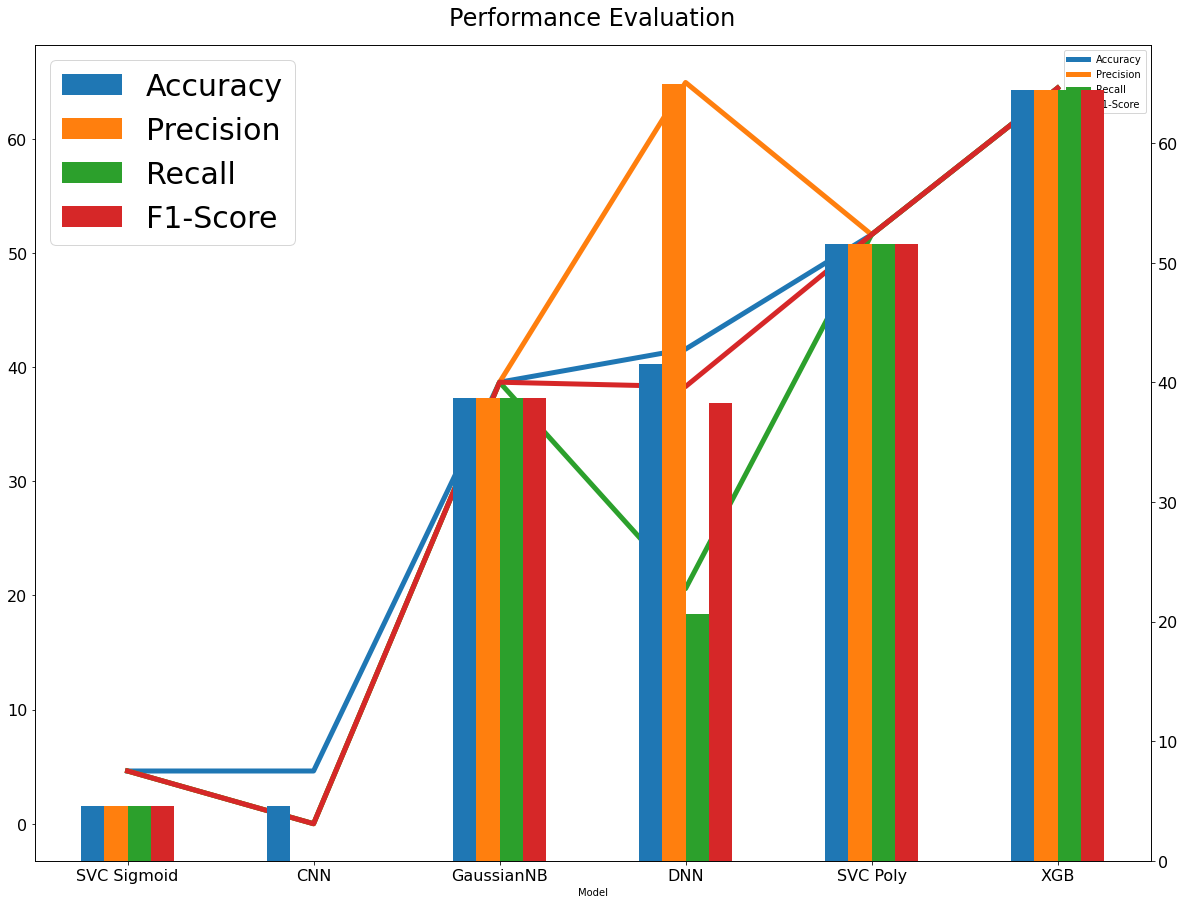

In [23]:
ax1 = df.plot(x='Model',figsize=(20,15),linewidth=5,kind='line',legend=True, fontsize=16)
ax2 = ax1.twinx()
ax3 = df.plot(x='Model',figsize=(20,15),kind='bar',legend=True, ax=ax2, fontsize=16)
ax3.set_title("Performance Evaluation", pad=20, fontdict={'fontsize':24})
ax3.legend(loc=2, fontsize = 30);
#ax3.set_ylabel('',fontdict={'fontsize':24})

Text(0.5, 1.0, 'Performance Evaluation')

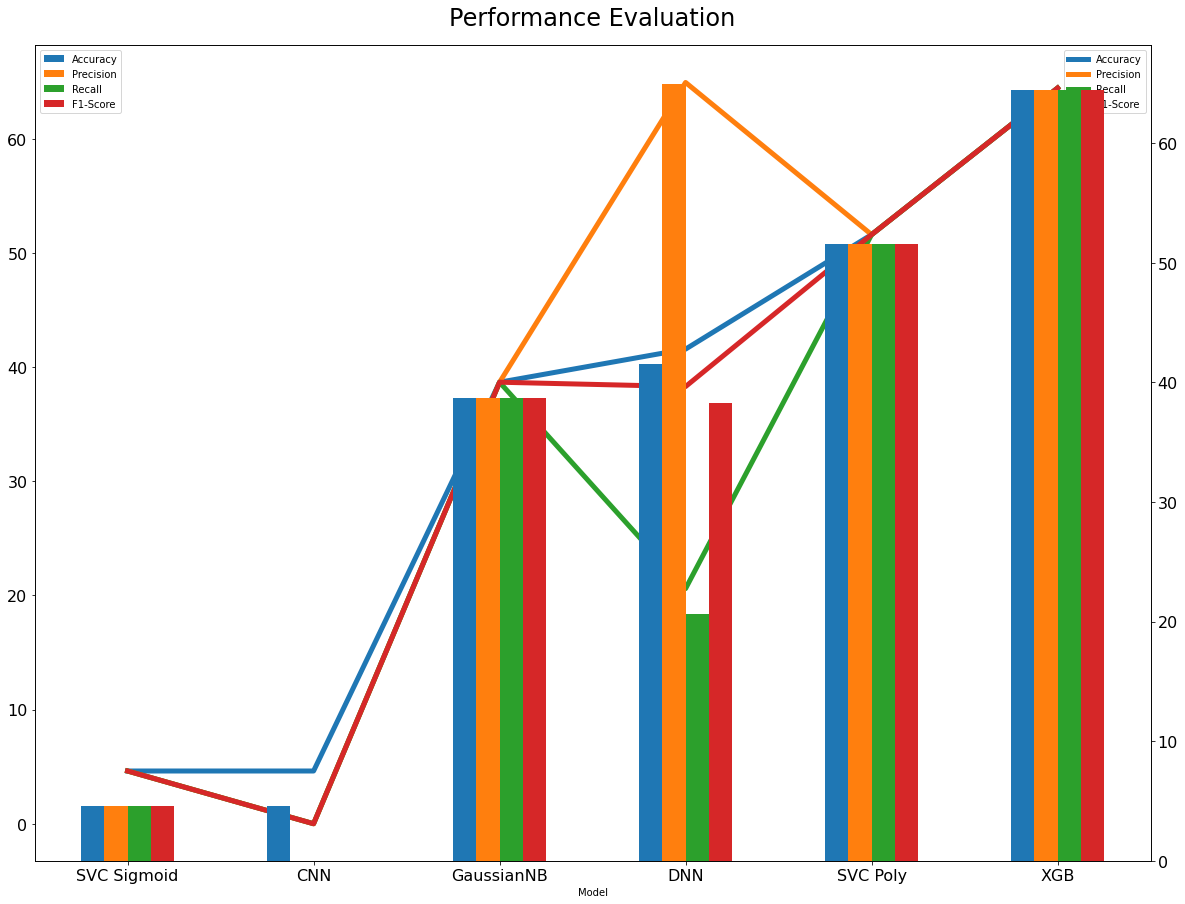

In [25]:
ax1 = df.plot(x='Model',figsize=(20,15),linewidth=5,kind='line',legend=True, fontsize=16)
ax2 = ax1.twinx()
ax3 = df.plot(x='Model',figsize=(20,15),kind='bar',legend=True, ax=ax2, fontsize=16)
ax3.set_title("Performance Evaluation", pad=20, fontdict={'fontsize':24})
#ax3.legend(loc=2, fontsize = 30);
#ax3.set_ylabel('',fontdict={'fontsize':24})